In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import holidays
import calendar
import datetime

In [3]:
from sklearn.metrics import mean_absolute_error

In [4]:
import optuna
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [5]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [6]:
data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
# Добавить 31ое
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
# Подправленные данные из-за дупликация в датах. То есть в одной дате прячется 2 транзакции. Просуммируем их. Только для Unit == 0
train_0d = train_0.groupby(train_0.index).sum()
# Делаем постоянное разрешение в 1 день и заполняем 0 появившиеся даты
train_0_1d = train_0d.resample('1D').sum()
# Нехватает последнего дня 2020 года - добавляем
train_0_1d = pd.concat([train_0_1d, pd.DataFrame([0], columns=["RUB"], index=[pd.to_datetime("2020-12-31")])])
train_0_1d.index.name = "Date"

In [10]:
train_0_1d.tail()

,RUB
Date,
2020-12-27,0.000000e+00
2020-12-28,0.000000e+00
2020-12-29,-7.605365e+08
2020-12-30,-5.518774e+05
2020-12-31,0.000000e+00


<AxesSubplot:xlabel='Date'>

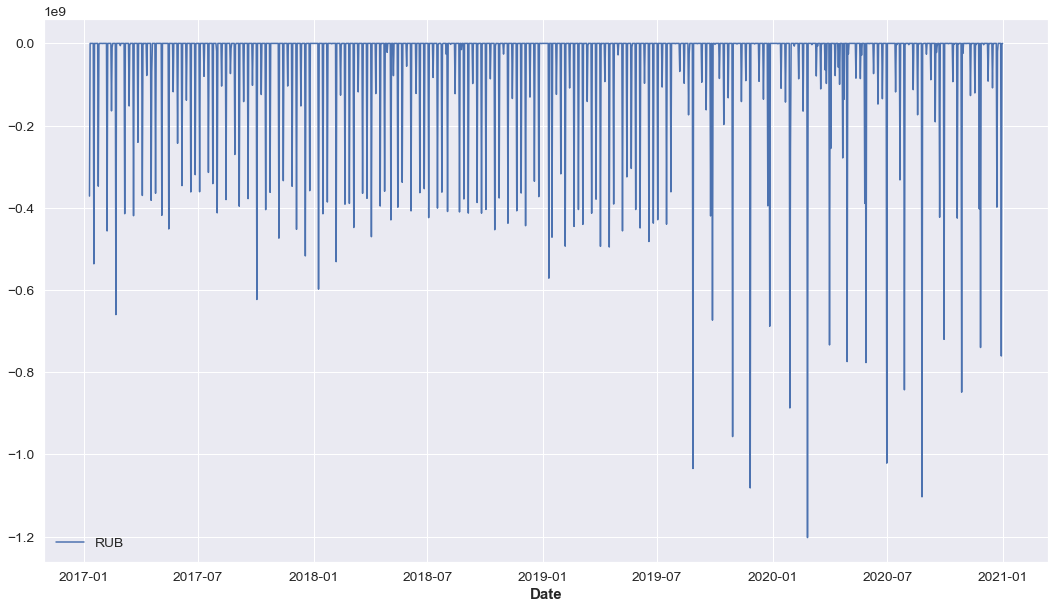

In [11]:
sns.lineplot(data=train_0_1d)

In [12]:
##############################################################################################################################################################################################

In [13]:
### Generalized valid data ###
# Данные, выданные к финалу - первый квартал 2021 года
data = pd.read_excel("1кв2021_1.xlsx")

In [15]:
# Работаем аналагично train
val = pd.DataFrame()
val["Unit"] = data["БЕ"]
val["Date"] = data["Расчет ликвидности - дата"]
val["RUB"] = data["Сумма в валюте транзакции"]

In [16]:
val_0 = val[val["Unit"]==0][["Date", "RUB"]]
val_0.set_index(pd.to_datetime(val_0["Date"], dayfirst=True), inplace=True)
val_0.drop("Date", inplace=True, axis=1)

val_1 = val[val["Unit"]==1][["Date", "RUB"]]
val_1.set_index(pd.to_datetime(val_1["Date"], dayfirst=True), inplace=True)
val_1.drop("Date", inplace=True, axis=1)

val_2 = val[val["Unit"]==2][["Date", "RUB"]]
val_2.set_index(pd.to_datetime(val_2["Date"], dayfirst=True), inplace=True)
val_2.drop("Date", inplace=True, axis=1)

val_3 = val[val["Unit"]==3][["Date", "RUB"]]
val_3.set_index(pd.to_datetime(val_3["Date"], dayfirst=True), inplace=True)
val_3.drop("Date", inplace=True, axis=1)

val_4 = val[val["Unit"]==4][["Date", "RUB"]]
val_4.set_index(pd.to_datetime(val_4["Date"], dayfirst=True), inplace=True)
val_4.drop("Date", inplace=True, axis=1)

val_5 = val[val["Unit"]==5][["Date", "RUB"]]
val_5.set_index(pd.to_datetime(val_5["Date"], dayfirst=True), inplace=True)
val_5.drop("Date", inplace=True, axis=1)

val_6 = val[val["Unit"]==6][["Date", "RUB"]]
val_6.set_index(pd.to_datetime(val_6["Date"], dayfirst=True), inplace=True)
val_6.drop("Date", inplace=True, axis=1)

<img src="https://miro.medium.com/max/1400/1*B1oKvhOuYoTdFEnwl8SEpg.png">

In [17]:
# Попробуем поработать в сторону фидбэка. Проверим, помогут дополнительные регрессоры. Эти регрессоры являются "Future covariates" (Рисунок 1).
# "Досемплирование" до полноценного первого квартала
# На самом деле больше, т.е. использование признаков в качестве future covariates вынуждает подсчитать признаки на 1 квартал + лаг на future covariates - это для валидации (valid set) И
# Подсчитать еще признаки дальше, для предсказания 2ого квартала (total set).
first_quarter = pd.DataFrame()
first_quarter.index = pd.date_range(start='1/1/2021', end='31/08/2021') # Немного с запасом
first_quarter["RUB"] = 0

val_0_1d = pd.DataFrame()
val_0_1d.index = pd.merge(val_0, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_0_1d.index.name = "Date"
val_0_1d["RUB"] = pd.merge(val_0, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_1_1d = pd.DataFrame()
val_1_1d.index = pd.merge(val_1, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_1_1d.index.name = "Date"
val_1_1d["RUB"] = pd.merge(val_1, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_2_1d = pd.DataFrame()
val_2_1d.index = pd.merge(val_2, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_2_1d.index.name = "Date"
val_2_1d["RUB"] = pd.merge(val_2, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_3_1d = pd.DataFrame()
val_3_1d.index = pd.merge(val_3, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_3_1d.index.name = "Date"
val_3_1d["RUB"] = pd.merge(val_3, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_4_1d = pd.DataFrame()
val_4_1d.index = pd.merge(val_4, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_4_1d.index.name = "Date"
val_4_1d["RUB"] = pd.merge(val_4, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_5_1d = pd.DataFrame()
val_5_1d.index = pd.merge(val_5, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_5_1d.index.name = "Date"
val_5_1d["RUB"] = pd.merge(val_5, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

val_6_1d = pd.DataFrame()
val_6_1d.index = pd.merge(val_6, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"].index
val_6_1d.index.name = "Date"
val_6_1d["RUB"] = pd.merge(val_6, first_quarter, how='outer', left_index=True, right_index=True).fillna(0)["RUB_x"]

In [18]:
##############################################################################################################################################################################################

In [19]:
# Feature engineering
# Добавляем регрессоры

In [23]:
def dayofweek(df):
    df["Dayofweek"] = df.index.dayofweek
    return df

In [24]:
def get_holidays(df):
    df["Holidays"] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('RUS').get(x)).values
    df["Holidays"] = df["Holidays"].astype('bool').astype('int')
    return df

In [25]:
def number_of_week_in_year(df):
    df["Number_of_week_in_year"] = df.index.isocalendar().week
    df["Number_of_week_in_year"] = df["Number_of_week_in_year"].astype(int)
    return df

In [26]:
def number_of_week_in_month(df):
    def week_of_month(tgtdate):
        days_this_month = calendar.mdays[tgtdate.month]
        for i in range(1, days_this_month):
            d = datetime.datetime(tgtdate.year, tgtdate.month, i)
            if d.day - d.weekday() > 0:
                startdate = d
                break
        return (tgtdate - startdate).days //7 + 1
    df["Number_of_week_in_month"] = df.index.to_series().apply(week_of_month)
    return df

In [27]:
def number_of_day_in_month(df):
    df["Number_of_day_in_month"] = df.index.day
    return df

In [28]:
def number_of_day_in_year(df):
    df["Number_of_day_in_year"] = df.index.dayofyear
    return df

In [29]:
def get_month(df):
    df["Month"] = df.index.month
    return df

In [30]:
def get_season(df):
    df["Season"] = df.index.month%12 // 3 + 1
    return df

In [31]:
def changepoint(df, date): # BU0: "2019-07-30"
    df["Changepoint"] = 0 
    df.loc[date:, "Changepoint"] = 1
    return df

In [32]:
def payday(df, payday): # BU0: "Tuesday"
    df["Payday"] = 0 
    df.loc[df.index.day_name() == payday, "Payday"] = 1
    return df

In [33]:
# Сводим через pipeline
(
    train_0_1d.pipe(dayofweek)
    .pipe(get_holidays)
    .pipe(number_of_week_in_year)
    .pipe(number_of_week_in_month)
    .pipe(number_of_day_in_month)
    .pipe(number_of_day_in_year)
    .pipe(get_month)
    .pipe(get_season)
    .pipe(changepoint, date="2019-07-30")
    .pipe(payday, payday="Tuesday")
)

,RUB,Dayofweek,Holidays,Number_of_week_in_year,Number_of_week_in_month,Number_of_day_in_month,Number_of_day_in_year,Month,Season,Changepoint,Payday
Date,,,,,,,,,,,
2017-01-10,-3.715272e+08,1,0,2,2,10,10,1,1,0,1
2017-01-11,0.000000e+00,2,0,2,2,11,11,1,1,0,0
2017-01-12,0.000000e+00,3,0,2,2,12,12,1,1,0,0
2017-01-13,0.000000e+00,4,0,2,2,13,13,1,1,0,0
2017-01-14,0.000000e+00,5,0,2,2,14,14,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.000000e+00,6,0,52,3,27,362,12,1,1,0
2020-12-28,0.000000e+00,0,0,53,4,28,363,12,1,1,0
2020-12-29,-7.605365e+08,1,0,53,4,29,364,12,1,1,1


In [34]:
(
    val_0_1d.pipe(dayofweek)
    .pipe(get_holidays)
    .pipe(number_of_week_in_year)
    .pipe(number_of_week_in_month)
    .pipe(number_of_day_in_month)
    .pipe(number_of_day_in_year)
    .pipe(get_month)
    .pipe(get_season)
    .pipe(changepoint, date="2019-07-30")
    .pipe(payday, payday="Tuesday")
)

,RUB,Dayofweek,Holidays,Number_of_week_in_year,Number_of_week_in_month,Number_of_day_in_month,Number_of_day_in_year,Month,Season,Changepoint,Payday
Date,,,,,,,,,,,
2021-01-01,0.0,4,1,53,0,1,1,1,1,1,0
2021-01-02,0.0,5,1,53,0,2,2,1,1,1,0
2021-01-03,0.0,6,1,53,0,3,3,1,1,1,0
2021-01-04,0.0,0,1,1,1,4,4,1,1,1,0
2021-01-05,0.0,1,1,1,1,5,5,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,0.0,4,0,34,4,27,239,8,3,1,0
2021-08-28,0.0,5,0,34,4,28,240,8,3,1,0
2021-08-29,0.0,6,0,34,4,29,241,8,3,1,0


In [35]:
list(train_0_1d.columns.values)
# RUB - искомая величина, остальные - регрессоры

['RUB',
 'Dayofweek',
 'Holidays',
 'Number_of_week_in_year',
 'Number_of_week_in_month',
 'Number_of_day_in_month',
 'Number_of_day_in_year',
 'Month',
 'Season',
 'Changepoint',
 'Payday']

In [36]:
##############################################################################################################################################################################################

In [37]:
# Darts модели

In [41]:
#train - данные до 2021
#val - данные первого квартала 2021
#total - их объединение
#covariates - общие для всех регрессоры
train_0_1d_reindex = train_0_1d["RUB"].reset_index(inplace=False)
train_0_1d_covariates = train_0_1d.drop("RUB", inplace=False, axis=1).reset_index()

val_0_1d_reindex = val_0_1d.loc["2021-01-01":"2021-03-31","RUB"].reset_index(inplace=False) #["RUB"]
val_0_1d_covariates = val_0_1d.drop("RUB", inplace=False, axis=1).reset_index()

In [294]:
total_0_1d = pd.concat([train_0_1d, val_0_1d.loc["2021-01-01":"2021-03-31"]])
total_0_1d_reindex = total_0_1d["RUB"].reset_index(inplace=False)

In [295]:
series_1d_total = TimeSeries.from_dataframe(total_0_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [42]:
# Для удобства работы. Данные не утекают
covariates = pd.concat([train_0_1d_covariates, val_0_1d_covariates])

In [45]:
# Перевод в формат, понятный darts
series_1d_train = TimeSeries.from_dataframe(train_0_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)
series_1d_val = TimeSeries.from_dataframe(val_0_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [47]:
# Один для всех ковариационный ряд признаков. Darts автоматически подбирает длину временного отрезка, данные из ковариационного ряда не "утекают" из будущего.
series_1d_future_covariates = TimeSeries.from_dataframe(
    covariates,
    time_col="Date",
    value_cols=[
        "Dayofweek",
        "Holidays",
        "Number_of_week_in_year",
        "Number_of_week_in_month",
        "Number_of_day_in_month",
        "Number_of_day_in_year",
        "Month",
        "Season",
        "Changepoint",
        "Payday",
    ],
    freq="1d",
    fill_missing_dates=True,
)

In [269]:
train_1d_split, local_val_1d_split = series_1d_train.split_before(0.80)
val_1d_split = series_1d_val

In [84]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [272]:
# Попробуем настроить модель через Optuna (как другие любые модели с гиперпараметрами)
def objective_LGB(trial):

    # 
    model1d = LightGBMModel(
        lags=None,
        lags_future_covariates=(61, 31),
        output_chunk_length=1,
        verbose=-1,
        metric="mae",
        n_estimators=1000,
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        lambda_l1=trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        lambda_l2=trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        min_gain_to_split=trial.suggest_float("min_gain_to_split", 0, 10.0),
        num_leaves=trial.suggest_int("num_leaves", 8, 256),
        feature_fraction=trial.suggest_uniform("feature_fraction", 0.0001, 1.0),
        bagging_fraction=trial.suggest_uniform("bagging_fraction", 0.0001, 1.0),
        bagging_freq=trial.suggest_int("bagging_freq", 0, 30),
        min_child_samples=trial.suggest_int("min_child_samples", 1, 100),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 3, 100),
        feature_pre_filter=False
    )  
    # Настройка на валид внутри train (local valid)
    model1d.fit(train_1d_split, future_covariates=series_1d_future_covariates)
    prediction1d = model1d.predict(n=len(local_val_1d_split), future_covariates=series_1d_future_covariates)
    fixed_prediction1d = prediction1d.pd_dataframe()
    fixed_prediction1d[fixed_prediction1d["RUB"] > 0] = 0
    local_val = mean_absolute_error(local_val_1d_split.pd_dataframe(), fixed_prediction1d)
    
    # Настройка на валид первого квартала 2021 года (данные, выданные к финалу)
    model1d.fit(series_1d_train, future_covariates=series_1d_future_covariates)
    prediction1d = model1d.predict(n=len(val_1d_split), future_covariates=series_1d_future_covariates)
    fixed_prediction1d = prediction1d.pd_dataframe()
    fixed_prediction1d[fixed_prediction1d["RUB"] > 0] = 0
    global_val = mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)
    
    # Как вариант, использовать усредненное значение MAE двух разбиений для оптимизации гиперпараметров
    val = np.mean([local_val, global_val])

    trial.set_user_attr("Valid_score", val)

    print(f"MAE: {val}\n")

    return val

In [273]:
study_LGB = optuna.create_study(direction="minimize")
study_LGB.optimize(objective_LGB, n_trials=300, gc_after_trial=True) #300 - можно и больше, но как показывает лог, этого более чем достаточно

[LightGBM] [Warning] feature_fraction is set=0.5547818475884507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5547818475884507
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_gain_to_split is set=5.134309102785435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.134309102785435
[LightGBM] [Warning] lambda_l1 is set=0.032366225094344905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032366225094344905
[LightGBM] [Warning] bagging_fraction is set=0.44486348945516985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44486348945516985
[LightGBM] [Warning] lambda_l2 is set=0.08139895301536125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08139895301536125
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is

In [274]:
# {'learning_rate': 0.0033925091118194714,
#  'lambda_l1': 2.77535161132449,
#  'lambda_l2': 6.645312703900074e-08,
#  'min_gain_to_split': 0.007569929139494697,
#  'num_leaves': 15,
#  'feature_fraction': 0.08465255152510917,
#  'bagging_fraction': 0.669833592883408,
#  'bagging_freq': 23,
#  'min_child_samples': 92,
#  'min_data_in_leaf': 5}
study_LGB.best_params

{'learning_rate': 0.0033925091118194714,
 'lambda_l1': 2.77535161132449,
 'lambda_l2': 6.645312703900074e-08,
 'min_gain_to_split': 0.007569929139494697,
 'num_leaves': 15,
 'feature_fraction': 0.08465255152510917,
 'bagging_fraction': 0.669833592883408,
 'bagging_freq': 23,
 'min_child_samples': 92,
 'min_data_in_leaf': 5}

In [275]:
model1d = LightGBMModel(
        lags=None,
        lags_future_covariates=(61, 31),
        output_chunk_length=1,
        verbose=-1,
        metric="mae",
        n_estimators=1000,
        learning_rate=0.0033925091118194714,
        lambda_l1=2.77535161132449,
        lambda_l2=6.645312703900074e-08,
        min_gain_to_split=0.007569929139494697,
        num_leaves=15,
        feature_fraction=0.08465255152510917,
        bagging_fraction=0.669833592883408,
        bagging_freq=23,
        min_child_samples=92,
        min_data_in_leaf=5,
        feature_pre_filter=False
    )  
model1d.fit(series_1d_train, future_covariates=series_1d_future_covariates)
prediction1d = model1d.predict(n=90, future_covariates=series_1d_future_covariates)

[LightGBM] [Warning] feature_fraction is set=0.08465255152510917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08465255152510917
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.007569929139494697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569929139494697
[LightGBM] [Warning] lambda_l1 is set=2.77535161132449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.77535161132449
[LightGBM] [Warning] bagging_fraction is set=0.669833592883408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.669833592883408
[LightGBM] [Warning] lambda_l2 is set=6.645312703900074e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.645312703900074e-08
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23


In [276]:
df_prediction1d = prediction1d.pd_dataframe()

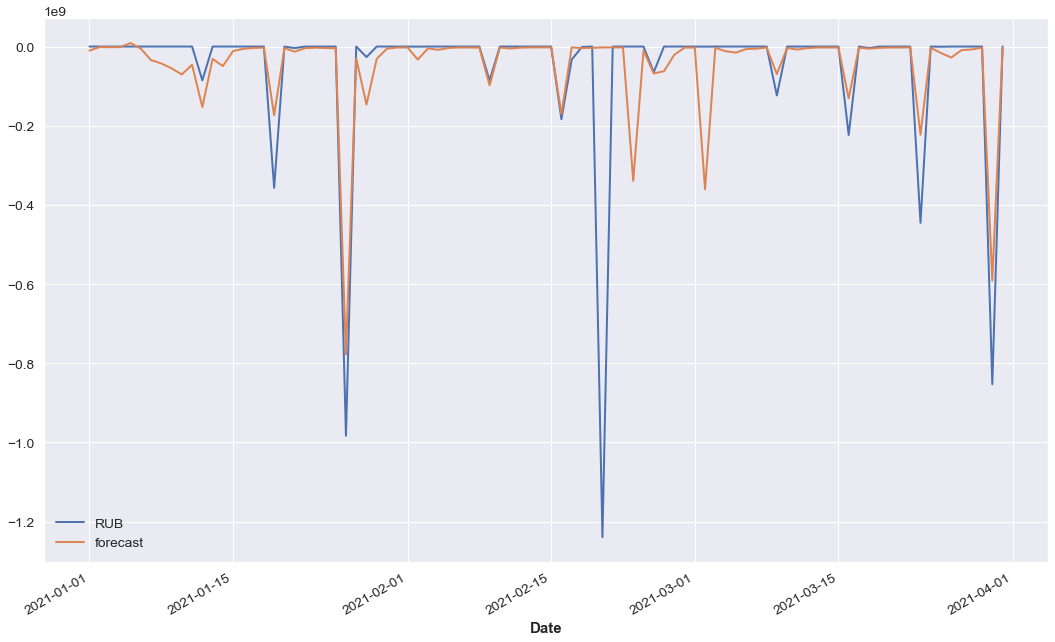

In [277]:
# В целом, LGB попадает в даты, часто даже понимает, где будет платеж больше, а где меньше. Один пик не видит совсем.
# Модель, которая строилась в отборе показывает качественно такой же результат (график приложен ниже).
series_1d_val.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [279]:
# Из графика видно, что правка минимальная
fixed_prediction1d = prediction1d.pd_dataframe()
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0

In [18]:
# Настройка ARIMA модели на пиковые платежи.
# AUTOArima построена поверх библиотеки pmdarima для python
# Все шаги аналогичны, только частота ряда 7 дней. Идея из отборочной стадии

In [162]:
#Делаем шаг по времени 7 дней
train_0_7d = train_0.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()
train_0_7d = train_0_7d.loc["2019-07-30":]

<AxesSubplot:xlabel='Date'>

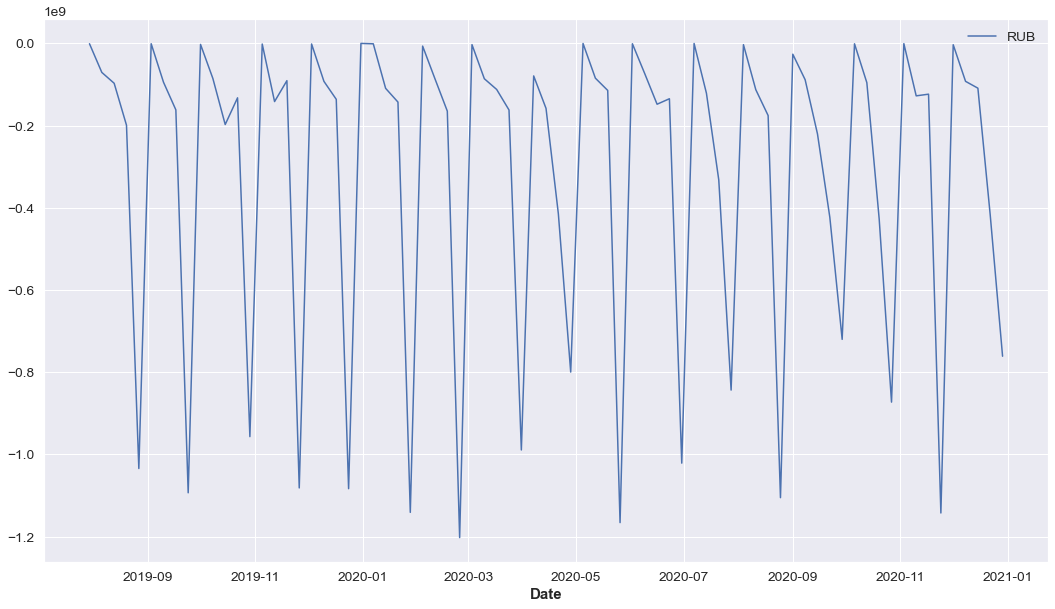

In [163]:
sns.lineplot(data=train_0_7d)

In [164]:
(
    train_0_7d.pipe(get_holidays)
    .pipe(number_of_week_in_year)
    .pipe(number_of_week_in_month)
    .pipe(get_month)
    .pipe(get_season)
)

,RUB,Holidays,Number_of_week_in_year,Number_of_week_in_month,Month,Season
Date,,,,,,
2019-07-30,-7.922119e+05,0,31,5,7,3
2019-08-06,-7.058271e+07,0,32,1,8,3
2019-08-13,-9.698551e+07,0,33,2,8,3
2019-08-20,-1.990443e+08,0,34,3,8,3
2019-08-27,-1.034238e+09,0,35,4,8,3
...,...,...,...,...,...,...
2020-12-01,-3.226283e+06,0,49,0,12,1
2020-12-08,-9.229390e+07,0,50,1,12,1
2020-12-15,-1.089283e+08,0,51,2,12,1


In [165]:
val_0_7d = val_0_1d["2021-01-05":]["RUB"].reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()

In [166]:
(
    val_0_7d.pipe(get_holidays)
    .pipe(number_of_week_in_year)
    .pipe(number_of_week_in_month)
    .pipe(get_month)
    .pipe(get_season)
)

,RUB,Holidays,Number_of_week_in_year,Number_of_week_in_month,Month,Season
Date,,,,,,
2021-01-05,0.000000e+00,1,1,1,1,1
2021-01-12,-8.529477e+07,0,2,2,1,1
2021-01-19,-3.609254e+08,0,3,3,1,1
2021-01-26,-1.009521e+09,0,4,4,1,1
2021-02-02,-2.149957e+05,0,5,1,2,1
2021-02-09,-8.572381e+07,0,6,2,2,1
2021-02-16,-1.456827e+09,0,7,3,2,1
2021-02-23,-6.463030e+07,1,8,4,2,1
2021-03-02,-2.471453e+05,0,9,1,3,2


In [167]:
train_0_7d_reindex = train_0_7d["RUB"].reset_index(inplace=False)
train_0_7d_covariates = train_0_7d.drop("RUB", inplace=False, axis=1).reset_index()

val_0_7d_reindex = val_0_7d.loc["2021-01-01":"2021-03-31","RUB"].reset_index(inplace=False) #["RUB"]
val_0_7d_covariates = val_0_7d.drop("RUB", inplace=False, axis=1).reset_index()

In [315]:
total_0_7d = pd.concat([train_0_7d, val_0_7d.loc["2021-01-01":"2021-03-31"]])
total_0_7d_reindex = total_0_7d["RUB"].reset_index(inplace=False)

In [316]:
series_7d_total = TimeSeries.from_dataframe(total_0_7d_reindex, time_col='Date', value_cols='RUB', freq='7d') #, fill_missing_dates=False

In [168]:
covariates_7d = pd.concat([train_0_7d_covariates, val_0_7d_covariates])

In [169]:
series_7d_train = TimeSeries.from_dataframe(train_0_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)
series_7d_val = TimeSeries.from_dataframe(val_0_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)

In [170]:
list(train_0_7d_covariates.columns.values)

['Date',
 'Holidays',
 'Number_of_week_in_year',
 'Number_of_week_in_month',
 'Month',
 'Season']

In [171]:
series_7d_future_covariates = TimeSeries.from_dataframe(
    covariates_7d,
    time_col="Date",
    value_cols=[
        "Holidays",
        "Number_of_week_in_year",
        "Number_of_week_in_month",
        "Month",
        "Season",
    ],
    freq="7d",
    fill_missing_dates=True,
)

In [172]:
train_7d_split = series_7d_train
val_7d_split = series_7d_val

In [176]:
model7d = AutoARIMA()
model7d.fit(train_7d_split, future_covariates=series_7d_future_covariates) # future_covariates=series_7d_future_covariates
prediction7d = model7d.predict(n=13, future_covariates=series_7d_future_covariates) # future_covariates=series_7d_future_covariates

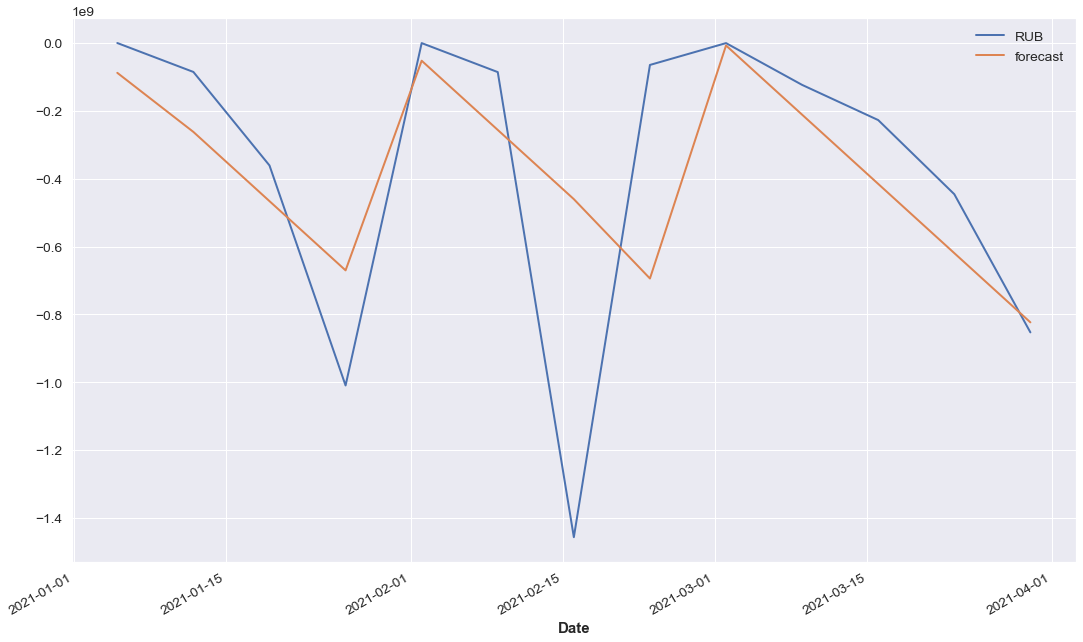

In [177]:
val_7d_split.plot()
prediction7d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [178]:
mean_absolute_error(val_7d_split.pd_dataframe(), prediction7d.pd_dataframe())

234163519.84225285

In [184]:
df_prediction7d = prediction7d.pd_dataframe()

In [196]:
df_prediction1d

component,RUB
Date,
2021-01-01,-6.820109e+06
2021-01-02,-4.613785e+06
2021-01-03,-4.680440e+06
2021-01-04,-4.223102e+06
2021-01-05,-1.984487e+07
...,...
2021-03-27,-1.150889e+07
2021-03-28,-6.964701e+06
2021-03-29,-5.245068e+06


In [195]:
df_prediction7d.resample("1D").sum()# + df_prediction1d

component,RUB
Date,
2021-01-05,-8.790901e+07
2021-01-06,0.000000e+00
2021-01-07,0.000000e+00
2021-01-08,0.000000e+00
2021-01-09,0.000000e+00
...,...
2021-03-26,0.000000e+00
2021-03-27,0.000000e+00
2021-03-28,0.000000e+00


In [202]:
df_prediction7d_resampled = pd.merge(df_prediction7d.resample("1D").sum(), first_quarter, how='outer', left_index=True, right_index=True).fillna(0).loc[:"2021-03-31"][["RUB_x"]]

In [284]:
# Здесь попробуем более простое решение - просто среднее двух моделей.
mean_absolute_error(val_0_1d_reindex["RUB"], (df_prediction1d["RUB"] + df_prediction7d_resampled["RUB_x"])/2.0)

37681764.9897198

In [285]:
val_df = pd.DataFrame()
val_df.index = df_prediction1d["RUB"].index
val_df["y"] = val_0_1d_reindex["RUB"].values
val_df["yhat"] = ((df_prediction1d["RUB"] + df_prediction7d_resampled["RUB_x"])/2.0)

In [286]:
BU0_group_stage = pd.read_csv("train_0_ans_ts.csv", usecols=[1,2])
BU0_group_stage.set_index("Дата транзакции", inplace=True)
BU0_group_stage.index.name = "Date"

In [287]:
val_df["yhat_groupstage"] = BU0_group_stage.loc[:"2021-03-31", "Сумма в RUB"].values

In [288]:
BU0_group_stage.loc[:"2021-03-31", "Сумма в RUB"]

Date
2021-01-01   -7.102442e+06
2021-01-02   -3.080713e+05
2021-01-03   -4.668611e+06
2021-01-04    0.000000e+00
2021-01-05   -4.705311e+07
                  ...     
2021-03-27   -5.474189e+06
2021-03-28   -2.568670e+07
2021-03-29    0.000000e+00
2021-03-30   -3.754963e+08
2021-03-31    0.000000e+00
Name: Сумма в RUB, Length: 90, dtype: float64

In [289]:
val_df

,y,yhat,yhat_groupstage
Date,,,
2021-01-01,0.000000e+00,-5.129543e+06,-7.102442e+06
2021-01-02,0.000000e+00,-5.901429e+05,-3.080713e+05
2021-01-03,0.000000e+00,-8.220208e+05,-4.668611e+06
2021-01-04,0.000000e+00,-7.025709e+05,0.000000e+00
2021-01-05,0.000000e+00,-3.948980e+07,-4.705311e+07
...,...,...,...
2021-03-27,0.000000e+00,-4.555288e+06,-5.474189e+06
2021-03-28,0.000000e+00,-3.667889e+06,-2.568670e+07
2021-03-29,0.000000e+00,-1.301389e+06,0.000000e+00


<AxesSubplot:xlabel='Date'>

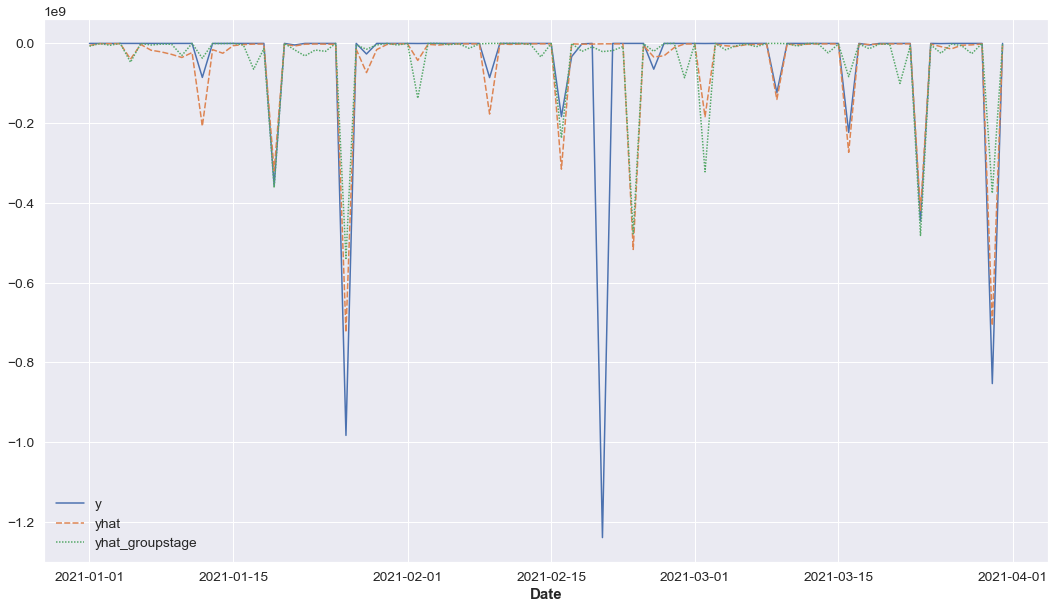

In [290]:
# y - истинное значение, yhat - значение новой модели, yhat_groupstage - значения старой модели. Качественно почти совпадают.
sns.lineplot(data=val_df)

In [291]:
# MAE от модели из отборов на первом квартале 2021 года. 30 000 000 => 48582347
mean_absolute_error(val_0_1d_reindex["RUB"], val_df["yhat_groupstage"])

48582347.947354846

In [296]:
##############################################################################################################################################################################################

In [297]:
# Refit на total

In [324]:
# Для LightGBM
model1d = LightGBMModel(
        lags=None,
        lags_future_covariates=(61, 31),
        output_chunk_length=1,
        verbose=-1,
        metric="mae",
        n_estimators=1000,
        learning_rate=0.0033925091118194714,
        lambda_l1=2.77535161132449,
        lambda_l2=6.645312703900074e-08,
        min_gain_to_split=0.007569929139494697,
        num_leaves=15,
        feature_fraction=0.08465255152510917,
        bagging_fraction=0.669833592883408,
        bagging_freq=23,
        min_child_samples=92,
        min_data_in_leaf=5,
        feature_pre_filter=False
    )  
model1d.fit(series_1d_total, future_covariates=series_1d_future_covariates)
prediction1d_total = model1d.predict(n=91, future_covariates=series_1d_future_covariates)
df_prediction1d_total = prediction1d_total.pd_dataframe()

[LightGBM] [Warning] feature_fraction is set=0.08465255152510917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08465255152510917
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.007569929139494697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007569929139494697
[LightGBM] [Warning] lambda_l1 is set=2.77535161132449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.77535161132449
[LightGBM] [Warning] bagging_fraction is set=0.669833592883408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.669833592883408
[LightGBM] [Warning] lambda_l2 is set=6.645312703900074e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.645312703900074e-08
[LightGBM] [Warning] bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23


In [320]:
model7d = AutoARIMA()
model7d.fit(series_7d_total, future_covariates=series_7d_future_covariates) # future_covariates=series_7d_future_covariates
prediction7d_total = model7d.predict(n=13, future_covariates=series_7d_future_covariates) # future_covariates=series_7d_future_covariates
df_prediction7d_total = prediction7d_total.pd_dataframe()

In [326]:
df_prediction7d_total_resampled = pd.merge(df_prediction7d_total.resample("1D").sum(), first_quarter, how='outer', left_index=True, right_index=True).fillna(0).loc["2021-04-01":"2021-06-30"][["RUB_x"]]

In [ ]:
val_df = pd.DataFrame()
val_df.index = df_prediction1d["RUB"].index
val_df["y"] = val_0_1d_reindex["RUB"].values
val_df["yhat"] = ((df_prediction1d["RUB"] + df_prediction7d_resampled["RUB_x"])/2.0)

In [336]:
#Собираем предикт вместе
train_0_ans_play_off = pd.DataFrame()
train_0_ans_play_off["Дата транзакции"] = pd.date_range(start="2021-04-01", end="2021-06-30", freq="1D")
train_0_ans_play_off["Сумма в RUB"] = ((df_prediction1d_total["RUB"] + df_prediction7d_total_resampled["RUB_x"])/2.0).values
train_0_ans_play_off["Сумма в RUB"] = train_0_ans_play_off["Сумма в RUB"].groupby(train_0_ans_play_off["Дата транзакции"].dt.month).cumsum().values

train_0_ans_play_off["Месяц"] = train_0_ans_play_off["Дата транзакции"].dt.month
train_0_ans_play_off["БЕ"] = 0


In [337]:
train_0_ans_play_off

,Дата транзакции,Сумма в RUB,Месяц,БЕ
0,2021-04-01,-6.759238e+06,4,0
1,2021-04-02,-1.620664e+07,4,0
2,2021-04-03,-1.787828e+07,4,0
3,2021-04-04,-1.949049e+07,4,0
4,2021-04-05,-2.059406e+07,4,0
...,...,...,...,...
86,2021-06-26,-5.242834e+08,6,0
87,2021-06-27,-5.290475e+08,6,0
88,2021-06-28,-5.302194e+08,6,0
89,2021-06-29,-1.155781e+09,6,0


In [338]:
train_0_ans_play_off.to_csv("train_0_ans_play_off.csv")